In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
!nvidia-smi

Sun Nov 10 03:44:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Imports

In [5]:
import random
from collections import Counter

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer
from torchvision import models, transforms

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Dataset Class

In [6]:
class ImageCaptionDataset(Dataset):
    def __init__(self, root_dir, captions_file, tokenizer, transform=None):
        self.root_dir = root_dir
        self.captions_file = pd.read_csv(captions_file)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.captions_file)

    def __getitem__(self, idx):
        img_name = self.captions_file.iloc[idx, 0]
        caption = self.captions_file.iloc[idx, 1]

        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # Tokenize the caption
        caption_tokens = self.tokenizer(caption, padding='max_length', max_length=30, truncation=True, return_tensors="pt")
        caption_tensor = caption_tokens['input_ids'].squeeze()  # Remove extra dimension

        return image, caption_tensor

In [7]:
def custom_collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
    return images, captions

### Getting bert tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [10]:
root_dir = '/kaggle/input/flickr8k/Images'
captions_file = '/kaggle/input/flickr8k/captions.txt'
dataset = ImageCaptionDataset(root_dir=root_dir, captions_file=captions_file, tokenizer=tokenizer, transform=transform)

## Making of Data Loaders

In [11]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

In [12]:
dataset_size

40455

In [13]:
train_size, test_size

(32364, 8091)

In [14]:
train_indices, test_indices = train_test_split(indices, train_size=train_size, test_size=test_size, random_state=42)

In [15]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

## Visualizing

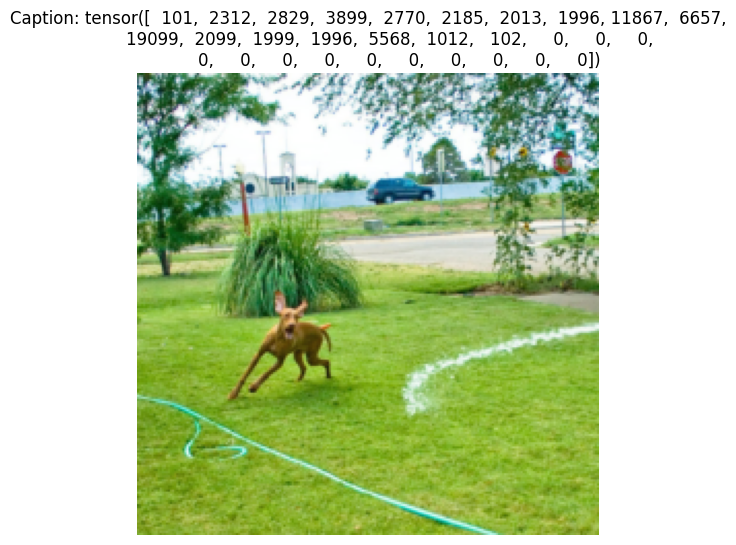

In [16]:
def visualize_image_with_caption(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)

    image, caption = dataset[index]

    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Caption: {caption}")
    plt.show()

visualize_image_with_caption(dataset, index=69)

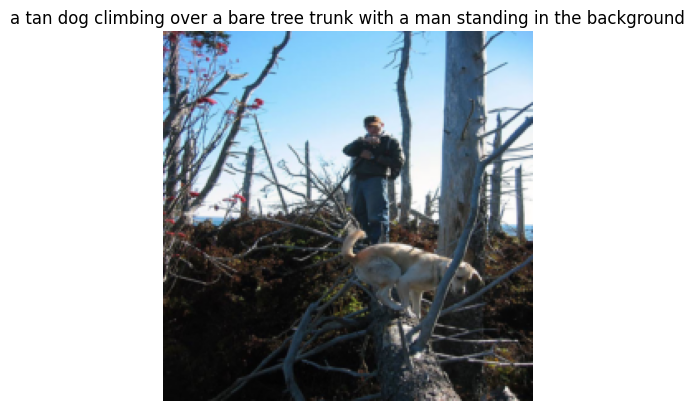

In [17]:
def visualize_image_with_caption(image, caption_tensor, tokenizer):
    image_np = image.squeeze(0).permute(1, 2, 0).numpy()
    image_np = np.clip(image_np, 0, 1)  

    caption_text = tokenizer.decode(caption_tensor.squeeze(), skip_special_tokens=True)
    
    plt.imshow(image_np)
    plt.title(caption_text)
    plt.axis('off')
    plt.show()

for images, captions in train_loader:
    visualize_image_with_caption(images[27], captions[27], tokenizer)
    break  

## Model

#### Encoder CNN

In [18]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        effinet = models.efficientnet_b5(pretrained=True)
        for param in effinet.parameters():
            param.requires_grad_(False)
        
        modules = list(effinet.children())[:-2]
        self.effinet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.effinet(images)                                   
        features = features.permute(0, 2, 3, 1)                           
        features = features.view(features.size(0), -1, features.size(-1)) 
        return features

#### Soft Attention i.e. Bahdanau Attention

In [19]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)
        self.A = nn.Linear(attention_dim, 1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     
        w_ah = self.W(hidden_state) 
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) 
        attention_scores = self.A(combined_states)        
        attention_scores = attention_scores.squeeze(2)    
        alpha = F.softmax(attention_scores, dim=1)    #attention_weight      
        attention_weights = features * alpha.unsqueeze(2)  
        attention_weights = attention_weights.sum(dim=1)  
        return alpha, attention_weights

#### Decoder LSTM

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(len(AutoTokenizer.from_pretrained('bert-base-uncased')), embed_size)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.fcn = nn.Linear(decoder_dim, self.embedding.num_embeddings)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = captions.size(1) - 1 
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.embedding.num_embeddings).to(features.device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(features.device)
                
        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            preds[:, s] = output
            alphas[:, s] = alpha  
        
        return preds, alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  
        c = self.init_c(mean_encoder_out)
        return h, c

#### Getting together both Encoder & Decoder

In [21]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            drop_prob=drop_prob
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs, alphas = self.decoder(features, captions)
        return outputs, alphas

In [22]:
from torch import nn, optim
model = EncoderDecoder(embed_size=300, attention_dim=256, encoder_dim=2048, decoder_dim=512).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 171MB/s]  
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set.

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=25e-5)

## Train Function

In [24]:
import torch
from torch import nn, optim
import os

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    print_every = 150
    
    os.makedirs('checkpoints', exist_ok=True)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for idx, (image, captions) in enumerate(train_loader):
            image, captions = image.to(device), captions.to(device)
            
            optimizer.zero_grad()
            
            outputs, _ = model(image, captions)
            targets = captions[:, 1:]  # shifted target for teacher forcing
            loss = criterion(outputs.view(-1, tokenizer.vocab_size), targets.reshape(-1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = outputs.max(2)
            mask = targets != tokenizer.pad_token_id
            correct_predictions += (predicted == targets).masked_select(mask).sum().item()
            total_predictions += mask.sum().item()
            
            if (idx + 1) % print_every == 0:
                avg_loss = running_loss / print_every
                accuracy = correct_predictions / total_predictions
                print(f"Epoch: {epoch}/{num_epochs}, Batch: {idx+1}/{len(train_loader)}, Loss: {avg_loss:.5f}, Accuracy: {accuracy:.5f}")
                running_loss = 0.0
                correct_predictions = 0
                total_predictions = 0
        
        #evaluating on test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.inference_mode():
            for image, captions in test_loader:
                image, captions = image.to(device), captions.to(device)
                outputs, _ = model(image, captions)
                targets = captions[:, 1:]
                loss = criterion(outputs.view(-1, tokenizer.vocab_size), targets.reshape(-1))
                test_loss += loss.item()
                
                _, predicted = outputs.max(2)
                mask = targets != tokenizer.pad_token_id
                test_correct += (predicted == targets).masked_select(mask).sum().item()
                test_total += mask.sum().item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = test_correct / test_total
        print(f"Epoch: {epoch}/{num_epochs}, Test Loss: {avg_test_loss:.5f}, Test Accuracy: {test_accuracy:.5f}")
        
        torch.save(model.state_dict(), f"checkpoints/model_weights_epoch_{epoch}.pth")
        print(f"Model weights saved for epoch {epoch}")


In [27]:
num_epochs = 25
train(model, train_loader, test_loader, criterion, optimizer, num_epochs, tokenizer)

Epoch: 1/25, Batch: 150/1265, Loss: 4.81615, Accuracy: 0.26567
Epoch: 1/25, Batch: 300/1265, Loss: 4.29370, Accuracy: 0.30993
Epoch: 1/25, Batch: 450/1265, Loss: 4.05273, Accuracy: 0.32846
Epoch: 1/25, Batch: 600/1265, Loss: 3.85062, Accuracy: 0.34406
Epoch: 1/25, Batch: 750/1265, Loss: 3.76369, Accuracy: 0.35199
Epoch: 1/25, Batch: 900/1265, Loss: 3.62806, Accuracy: 0.36503
Epoch: 1/25, Batch: 1050/1265, Loss: 3.58996, Accuracy: 0.36803
Epoch: 1/25, Batch: 1200/1265, Loss: 3.48282, Accuracy: 0.37759
Epoch: 1/25, Test Loss: 3.28940, Test Accuracy: 0.39389
Model weights saved for epoch 1
Epoch: 2/25, Batch: 150/1265, Loss: 3.30959, Accuracy: 0.39081
Epoch: 2/25, Batch: 300/1265, Loss: 3.28602, Accuracy: 0.38766
Epoch: 2/25, Batch: 450/1265, Loss: 3.23838, Accuracy: 0.39533
Epoch: 2/25, Batch: 600/1265, Loss: 3.21106, Accuracy: 0.39922
Epoch: 2/25, Batch: 750/1265, Loss: 3.16841, Accuracy: 0.40226
Epoch: 2/25, Batch: 900/1265, Loss: 3.15735, Accuracy: 0.40328
Epoch: 2/25, Batch: 1050/126

## Saving the model

In [28]:
checkpoint = torch.load("/kaggle/working/checkpoints/model_weights_epoch_25.pth", map_location=device)
model.load_state_dict(checkpoint)

/tmp/ipykernel_30/1974660544.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/checkpoints/model_weights_epoch_25.pth", map_locati

<All keys matched successfully>

In [29]:
torch.save(model.state_dict(), "model_weights.pth")

## Inference

In [31]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

embed_size = 300
vocab_size = tokenizer.vocab_size  
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
drop_prob = 0.3

model = EncoderDecoder(
    embed_size=embed_size,
    
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    drop_prob=drop_prob
).to(device)

model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def predict_caption(image_path, model, tokenizer, max_len=50):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    features = model.encoder(image_tensor)
    
    h, c = model.decoder.init_hidden_state(features)
    
    #Starting the caption with the [CLS] token
    word = torch.tensor([tokenizer.cls_token_id]).to(device)
    embeds = model.decoder.embedding(word)
    
    captions = []
    alphas = []
    
    for _ in range(max_len):
        alpha, context = model.decoder.attention(features, h)
        alphas.append(alpha.cpu().detach().numpy())
        
        lstm_input = torch.cat((embeds.squeeze(1), context), dim=1)
        h, c = model.decoder.lstm_cell(lstm_input, (h, c))
        
        output = model.decoder.fcn(model.decoder.drop(h))
        predicted_word_idx = output.argmax(dim=1)
        
        captions.append(predicted_word_idx.item())
        
        #Break if [SEP] token is generated
        if predicted_word_idx.item() == tokenizer.sep_token_id:
            break
        
        embeds = model.decoder.embedding(predicted_word_idx.unsqueeze(0))
    
    #Converting word indices to words & skipping special tokens
    caption = tokenizer.decode(captions, skip_special_tokens=True)
    return image, caption

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date we

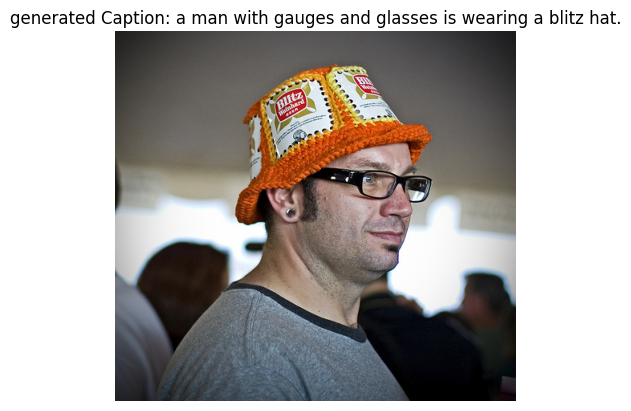

In [32]:
image_path = "/kaggle/input/flickr8k/Images/1007129816_e794419615.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()

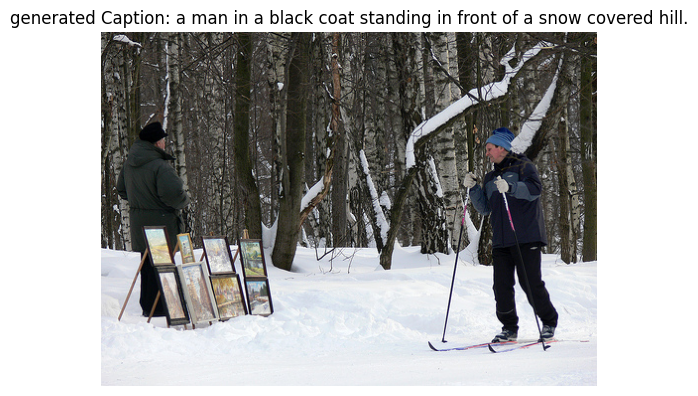

In [33]:
image_path = "/kaggle/input/flickr8k/Images/101669240_b2d3e7f17b.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()

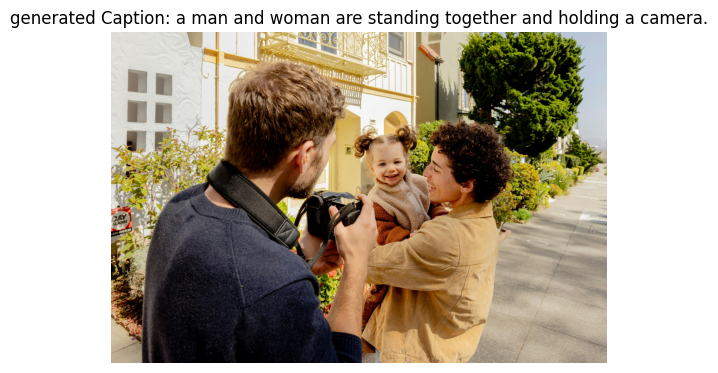

In [34]:
image_path = "/kaggle/input/llllll/samsung-memory-seUxMX-DhAQ-unsplash.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()

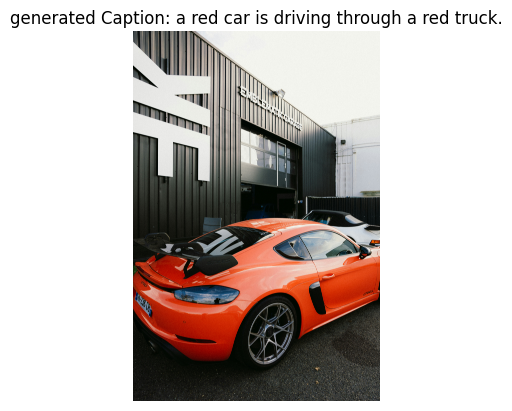

In [35]:
image_path = "/kaggle/input/llllll/mathias-reding-Cqa26OOubMs-unsplash.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()

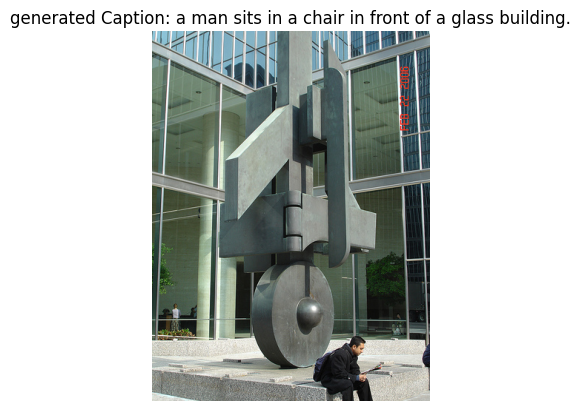

In [36]:
image_path = "/kaggle/input/flickr8k/Images/103195344_5d2dc613a3.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()

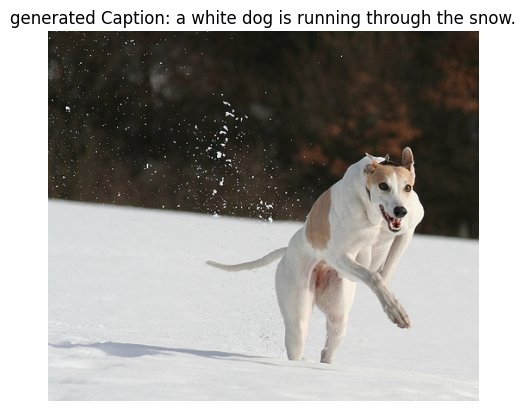

In [40]:
image_path = "/kaggle/input/flickr8k/Images/101654506_8eb26cfb60.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()

## BLEU Score for FUNNNN!!!

In [37]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(predicted_captions, ground_truth_captions):

    predicted_captions = [caption.split() for caption in predicted_captions]
    ground_truth_captions = [[caption.split()] for caption in ground_truth_captions]  
    
    bleu_score = corpus_bleu(ground_truth_captions, predicted_captions)
    return bleu_score


In [38]:
def evaluate_model(model, test_loader, tokenizer):
    model.eval()
    predicted_captions = []
    ground_truth_captions = []
    
    with torch.no_grad():
        for image, captions in test_loader:
            image = image.to(device)
            captions = captions.to(device)
            
            outputs, _ = model(image, captions)
            
            _, predicted = outputs.max(2)
            predicted = predicted.cpu().numpy()

            for idx in range(predicted.shape[0]):
                predicted_caption = tokenizer.decode(predicted[idx], skip_special_tokens=True)
                predicted_captions.append(predicted_caption)
                
                ground_truth_caption = tokenizer.decode(captions[idx, 1:], skip_special_tokens=True)
                ground_truth_captions.append(ground_truth_caption)

    #Calculate BLEU score
    bleu_score = calculate_bleu(predicted_captions, ground_truth_captions)
    print(f"BLEU Score: {bleu_score:.4f}")
    return bleu_score


In [39]:
bleu_score = evaluate_model(model, test_loader, tokenizer)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


BLEU Score: 0.1814
